In [187]:
import wrds
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import getenv, path
from pathlib import Path

In [188]:
# dynamic to decide logon info to login to wrds
def pgpass_dir():
    if sys.platform.startswith('win'):
        os_path = getenv('LOCALAPPDATA')
        file_path = os_path+'\postgresql\pgpass.conf'
        print (file_path)
    elif sys.platform.startswith('darwin'):
        if path.exists('/Users/argool/.pgpass'):
            file_path = '/Users/argool/.pgpass'
        else:
            dir_path = os.path.dirname('/Users/')
            keyword = '.pgpass'
            for root, dirs, files in os.walk(dir_path):
                for file in files:
                    if keyword in file:
                        file_path = root+'/'+str(file)
    return file_path        

In [189]:
%%time
# get file from system. it takes a little bit time.
file_path = pgpass_dir()

CPU times: user 54 µs, sys: 121 µs, total: 175 µs
Wall time: 1.21 ms


In [190]:
with open(file_path,'r') as f:
    output = f.read()
    login_id = output.split(":")[3]
    crsp_db = wrds.Connection(wrds_username=login_id)

Loading library list...
Done


In [191]:
# crsp_db = wrds.Connection(wrds_username='ningtong88')

In [192]:
#initialize the balance and weight
Starting_Balance = 10000
portfolio_weights = np.array([0.5, 0.4, 0.1])

In [193]:
#ticker_list = {'tickers': ('GLD', 'SPY', 'TLT','QQQ','JNK','IWM')}
ticker_list = {'tickers': ('GLD', 'SPY', 'TLT')}


In [194]:
crsp_db.raw_sql('SELECT permco, permno, ticker, comnam FROM crsp.stocknames WHERE ticker in %(tickers)s group by permco, permno, ticker, comnam order by 3 asc', params=ticker_list)

,permco,permno,ticker,comnam
0,23150.0,22568.0,GLD,GOULD INC
1,23407.0,26411.0,GLD,GLADDING MC BEAN & CO
2,30433.0,80694.0,GLD,SANTA FE PACIFIC GOLD CORP
3,45874.0,90448.0,GLD,SPDR GOLD TRUST
4,45874.0,90448.0,GLD,STREETTRACKS GOLD TRUST
5,2751.0,33910.0,SPY,SPEEDRY CHEMICAL PRODS INC
6,4215.0,60716.0,SPY,SPECTRA PHYSICS INC
7,46699.0,84398.0,SPY,SPDR S & P 500 E T F TRUST
8,46699.0,84398.0,SPY,SPDR TRUST
9,37493.0,89468.0,TLT,ISHARES TRUST


In [195]:
crsp_db.raw_sql('SELECT permco, permno, ticker, comnam FROM crsp.stocknames WHERE ticker in %(tickers)s \
    and comnam like \'%%TRUST\' group by permco, permno, ticker, comnam order by 3 asc', params=ticker_list)

,permco,permno,ticker,comnam
0,45874.0,90448.0,GLD,SPDR GOLD TRUST
1,45874.0,90448.0,GLD,STREETTRACKS GOLD TRUST
2,46699.0,84398.0,SPY,SPDR S & P 500 E T F TRUST
3,46699.0,84398.0,SPY,SPDR TRUST
4,37493.0,89468.0,TLT,ISHARES TRUST


In [196]:
#generate permno list as tuple
permno_df = crsp_db.raw_sql('select distinct permno from (SELECT permco, permno, ticker, comnam FROM crsp.stocknames WHERE ticker in %(tickers)s \
    and comnam like \'%%TRUST\' group by permco, permno, ticker, comnam order by 3 asc) a', params=ticker_list)
permno_list_string = permno_df.permno.astype(str).values.tolist()
permno_tuple = tuple(permno_list_string)
permno_list_1 = {'permno': permno_tuple}

In [197]:
# #Permnos for GLD, SPY, and TLT
# permno_list_1 = {'permno': ('90448.0','84398.0','89468.0')}


In [198]:
# dsf_keep = crsp_db.raw_sql('select distinct b.ticker, a.permno, a.date, a.bidlo, a.askhi, \
#     a.prc, a.bid, a.vol, a.ret from crspm.dsf a, crsp.stocknames b \
#     where a.permno in %(permno)s and a.permno = b.permno order by 1,2,3 asc', 
#                 params=permno_list_1,date_cols=['date'], index_col=['permno'])

In [199]:
crsp_db.raw_sql('select distinct permno, min(date), max(date) from crspm.dsf where permno in %(permno)s group by permno order by 2 asc', params=permno_list_1,date_cols=['date'], index_col=['permno'])

,min,max
permno,,
84398.0,1993-01-29,2020-10-30
89468.0,2002-07-26,2020-10-30
90448.0,2004-11-18,2020-10-30


In [200]:
#list earlest date covered by three ETF
crsp_db.raw_sql('select max(min_date) as start_time from (select distinct permno, min(date) over (partition by permno) as min_date from crspm.dsf where permno in %(permno)s) a',params=permno_list_1,date_cols=['date'])

,start_time
0,2004-11-18


In [201]:
#Keep only the data for the assets we want and also only keep the time period that all assets are active
dsf_filtered = crsp_db.raw_sql('select distinct b.ticker, a.permno, a.date, a.bidlo, a.askhi, a.prc, a.bid, a.vol, a.ret from crspm.dsf a, crsp.stocknames b, \
    (select max(min_date) as start_time from (select distinct permno, min(date) over (partition by permno) as min_date from crspm.dsf where permno in %(permno)s) temp) as c \
where a.permno in %(permno)s and a.permno = b.permno and a.date >= c.start_time order by 1,2,3 asc', params=permno_list_1,date_cols=['date'],index_col=['permno'])

In [17]:
# etf_incept_date_range = crsp_db.raw_sql('select distinct permno, min(date), max(date) from crspm.dsf where permno in %(permno)s group by permno order by 2 asc', params=permno_list_1,date_cols=['date'], index_col=['permno'])

In [18]:
#Keep only the data for the assets we want and also only keep the time period that all assets are active
# dsf_filtered = dsf_keep[dsf_keep['date'].dt.date >= etf_incept_date_range['min'].max()]

In [19]:
dsf_filtered.set_index('date', inplace=True)
# df1 = dsf_filtered.pivot(index='date', columns='ticker', values=['prc','ret'])
# df1 = dsf_filtered.pivot(columns='ticker', values=['prc','ret'])

In [20]:
spy_ret = dsf_filtered[dsf_filtered['ticker']=='SPY']
TLT_ret = dsf_filtered[dsf_filtered['ticker']=='TLT']
gld_ret = dsf_filtered[dsf_filtered['ticker']=='GLD']

In [21]:
ret_only = pd.DataFrame([spy_ret['ret'],TLT_ret['ret'],gld_ret['ret']]).transpose()
ret_only.columns = ['spy_ret', 'tlt_ret', 'gld_ret']
ret_only = ret_only.iloc[1:]
#ret_only

In [22]:
spy_ret = dsf_filtered[dsf_filtered['ticker']=='SPY']
TLT_ret = dsf_filtered[dsf_filtered['ticker']=='TLT']
gld_ret = dsf_filtered[dsf_filtered['ticker']=='GLD']
prc_only = pd.DataFrame([spy_ret['prc'],TLT_ret['prc'],gld_ret['prc']]).transpose()
prc_only.columns = ['spy_prc', 'tlt_prc', 'gld_prc']
prc_only = prc_only.iloc[1:]
numeric_cols_prc = [col for col in prc_only if prc_only[col].dtype.kind != 'O']

In [23]:
all_data =  pd.concat([prc_only, ret_only], axis=1)

In [24]:
all_data.reset_index(level=0, inplace=True)
all_data['mdate'] = all_data['date'].dt.to_period("M")
#portfolio_return['ret_1']= portfolio_return['ret']

In [25]:
#Add 1 to all the returns then to perform monthly return calc.
numeric_cols = [col for col in ret_only if ret_only[col].dtype.kind != 'O']
#numeric_cols.pop(0)
all_data[numeric_cols] += 1

In [26]:
#del numeric_cols[-1]
numeric_cols_new = [s + "_daily" for s in numeric_cols]
#ret_only[numeric_cols_new] = portfolio_weights

In [27]:
all_data[numeric_cols_new] = all_data[numeric_cols].cumprod()
port_weight = all_data[numeric_cols_new].mul(portfolio_weights)

In [28]:
port_weight['raw_tot']=port_weight[numeric_cols_new].sum(axis=1)
#numeric_cols_new = [s + "Updated Weight" for s in numeric_cols]
#port_ret = pd.DataFrame(port_ret,columns = [numeric_cols_new])
numeric_cols_new_1 = [s + "_weight" for s in numeric_cols]

In [39]:
port_weight[numeric_cols_new_1]=port_weight[numeric_cols_new].div(port_weight['raw_tot'].values,axis=0)

In [47]:
portfolio_return =  pd.concat([all_data, port_weight[numeric_cols_new_1]], axis=1)

In [69]:
portfolio_return_1 = portfolio_return.drop(numeric_cols, axis = 1) 

In [72]:
#portfolio_return_1['Portfolio Daily Return'] = np.dot(portfolio_return_1.filter(like='ret_daily'),portfolio_return_1.filter(like='ret_weight').T)
portfolio_return_1['Portfolio Daily Return'] = (portfolio_return_1.filter(like='ret_daily').to_numpy()
                                                *portfolio_return_1.filter(like='ret_weight').to_numpy()).sum(axis=1)

#portfolio_return_1['Trading_Day_Counter'] = range(len(portfolio_return_1))

In [180]:
rebalance_days = 126
#avoid 0 as the 1st starting point
total_times = round(len(portfolio_return_1)/rebalance_days)
#starting with day 1 rather than 0
day_one = 1
stop_time = total_times + day_one
for row in range(1,stop_time):
    # portfolio_return_1.loc[row*180,'rebalance_flag'] = 'Y'
    rebalance_date = row * rebalance_days
    portfolio_return_1.loc[rebalance_date,'rebalance_flag'] = 'Y'
    print(portfolio_return_1.loc[rebalance_date,])

#Introudce # of shares variables to get the total value of the portfolio at any given point
numeric_cols_shares = [s + "_shares" for s in numeric_cols]

prc                                 109.3
tlt_prc                                101.28
gld_prc                                117.34
mdate                                 2010-08
spy_ret_daily                         1.03187
tlt_ret_daily                         1.46205
gld_ret_daily                         2.64398
spy_ret_weight                       0.377931
tlt_ret_weight                       0.428392
gld_ret_weight                       0.193677
Portfolio Daily Return                1.52839
Trading_Day_Counter                      1440
rebalance_flag                              Y
Name: 1440, dtype: object
date                      2011-04-28 00:00:00
spy_prc                                136.11
tlt_prc                                  93.6
gld_prc                                149.82
mdate                                 2011-04
spy_ret_daily                         1.30426
tlt_ret_daily                         1.38945
gld_ret_daily                         3.37585
spy_ret_weig

In [183]:
#validate
portfolio_return_1.loc[portfolio_return_1['rebalance_flag'] == 'Y']

In [467]:
# rebalance_days = 180
# for rows in range(len(portfolio_return_1)):
#     if portfolio_return_1.loc[rows,'Trading_Day_Counter'] % rebalance_days == 0:
#         portfolio_return_1.loc[rows,'rebalance_flag'] = 'Y'
#         print(portfolio_return_1.loc[rows,])
#     else:
#         portfolio_return_1.loc[rows,'rebalance_flag'] = 'N'
#Introudce # of shares variables to get the total value of the portfolio at any given point
# numeric_cols_shares = [s + "_shares" for s in numeric_cols]        

date                      2004-11-19 00:00:00
spy_prc                                117.42
tlt_prc                                 88.26
gld_prc                                 44.78
mdate                                 2004-11
spy_ret_daily                        0.988883
tlt_ret_daily                         0.99202
gld_ret_daily                         1.00901
spy_ret_weight                       0.498353
tlt_ret_weight                       0.399947
gld_ret_weight                         0.1017
Portfolio Daily Return               0.992185
Trading_Day_Counter                         0
rebalance_flag                              Y
Name: 0, dtype: object
date                      2005-08-09 00:00:00
spy_prc                                123.39
tlt_prc                                 91.83
gld_prc                                 43.34
mdate                                 2005-08
spy_ret_daily                         1.05243
tlt_ret_daily                         1.06666
gld_ret_dai

date                      2015-08-13 00:00:00
spy_prc                                208.66
tlt_prc                                123.67
gld_prc                                106.86
mdate                                 2015-08
spy_ret_daily                         2.18104
tlt_ret_daily                         2.08836
gld_ret_daily                         2.40784
spy_ret_weight                       0.503322
tlt_ret_weight                       0.385546
gld_ret_weight                       0.111132
Portfolio Daily Return                2.17051
Trading_Day_Counter                      2700
rebalance_flag                              Y
Name: 2700, dtype: object
date                      2016-05-02 00:00:00
spy_prc                                207.97
tlt_prc                                127.82
gld_prc                                123.24
mdate                                 2016-05
spy_ret_daily                         2.20985
tlt_ret_daily                         2.19875
gld_ret_

In [184]:
portfolio_return_1['Portfolio_Value'] = portfolio_return_1['Portfolio Daily Return']*Starting_Balance

##########Stopped here Ning#####

In [473]:
#if portfolio_return_1.loc[rows,'rebalance_flag'] == 'Y':
#    portfolio_return_1[numeric_cols_shares] = (portfolio_return_1['Portfolio_Value'] * portfolio_weights)/portfolio_return_1[numeric_cols_prc]
#else:
#    portfolio_return_1[numeric_cols_shares] 

In [475]:
numeric_cols_shares

['spy_ret_shares', 'tlt_ret_shares', 'gld_ret_shares']

In [ ]:
#Rebalance every 2 years
start_date = portfolio_return_1['date'].min()


In [169]:
#np.product(portfolio_return[numeric_cols])
monthly_total = portfolio_return.groupby('mdate').prod()-1

In [170]:
monthly_total

,spy_ret,tlt_ret,gld_ret,Portfolio Daily Return
mdate,,,,
2004-11,-0.005819,-0.019842,0.016674,-0.009198
2004-12,0.030153,0.026566,-0.029255,0.022902
2005-01,-0.022421,0.035686,-0.036073,-0.000765
2005-02,0.020904,-0.014720,0.030791,0.007692
2005-03,-0.018281,-0.004542,-0.016085,-0.012424
...,...,...,...,...
2020-05,0.047645,-0.017629,0.025882,0.019915
2020-06,0.017761,0.003376,0.027377,0.014700
2020-07,0.058892,0.044352,0.107905,0.058332


In [110]:
multpl_stock_daily_returns = df1['prc'].pct_change()
multpl_stock_monthly_returns = df1['prc'].resample('M').ffill().pct_change()

<Figure size 432x288 with 0 Axes>

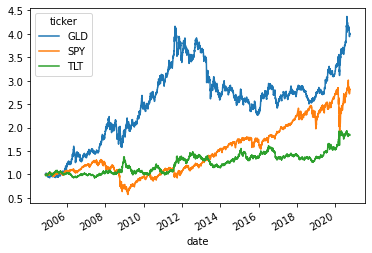

In [111]:
fig = plt.figure()
(multpl_stock_daily_returns + 1).cumprod().plot()
plt.show()

In [ ]:
portfolio_weights = np.array([0.5, 0.4, 0.1])

prc                               ret                    
ticker             GLD         SPY         TLT       GLD       SPY       TLT
date                                                                        
2004-11-18   44.380001  118.739998   88.970001       NaN  0.001349  0.003044
2004-11-19   44.779999  117.419998   88.260002  0.009013 -0.011117 -0.007980
2004-11-22   44.950001  117.980003   88.720001  0.003796  0.004769  0.005212
2004-11-23   44.750000  118.160004   88.830002 -0.004449  0.001526  0.001240
2004-11-24   45.049999  118.440002   88.830002  0.006704  0.002370  0.000000
...                ...         ...         ...       ...       ...       ...
2020-09-24  175.440002  323.500000  165.119995  0.003719  0.002665  0.003830
2020-09-25  174.940002  328.730011  165.119995 -0.002850  0.016167  0.000000
2020-09-28  176.699997  334.190002  164.649994  0.010061  0.016609 -0.002846
2020-09-29  178.190002  332.369995  164.839996  0.008432 -0.005446  0.001154
2020-09-30  177.119995  334.890015  163.259995 -0.006005  0.007582 -0.009585

[3994 rows x 6 columns]

In [118]:
list(df1)
df_test_1 = pd.DataFrame(df1)
df_test_1.reset_index(level=0, inplace=True)

In [119]:
df_test_1

date         prc                               ret            \
ticker                    GLD         SPY         TLT       GLD       SPY   
0      2004-11-18   44.380001  118.739998   88.970001       NaN  0.001349   
1      2004-11-19   44.779999  117.419998   88.260002  0.009013 -0.011117   
2      2004-11-22   44.950001  117.980003   88.720001  0.003796  0.004769   
3      2004-11-23   44.750000  118.160004   88.830002 -0.004449  0.001526   
4      2004-11-24   45.049999  118.440002   88.830002  0.006704  0.002370   
...           ...         ...         ...         ...       ...       ...   
3989   2020-09-24  175.440002  323.500000  165.119995  0.003719  0.002665   
3990   2020-09-25  174.940002  328.730011  165.119995 -0.002850  0.016167   
3991   2020-09-28  176.699997  334.190002  164.649994  0.010061  0.016609   
3992   2020-09-29  178.190002  332.369995  164.839996  0.008432 -0.005446   
3993   2020-09-30  177.119995  334.890015  163.259995 -0.006005  0.007582   

                  
ticker       TLT  
0       0.003044  
1      -0.007980  
2       0.005212  
3       0.001240  
4       0.000000  
...          ...  
3989    0.003830  
3990    0.000000  
3991   -0.002846  
3992    0.001154  
3993   -0.009585  

[3994 rows x 7 columns]

In [71]:
list(df1)
df2 = df1[('ret', 'GLD')]

In [72]:

df_test_1 = pd.DataFrame(df2)
df_test_1.columns = ['return']
df_test_1.reset_index(level=0, inplace=True)

In [97]:
df_test_1

,date,return
0,2004-11-18,NaN
1,2004-11-19,0.009013
2,2004-11-22,0.003796
3,2004-11-23,-0.004449
4,2004-11-24,0.006704
...,...,...
3989,2020-09-24,0.003719
3990,2020-09-25,-0.002850
3991,2020-09-28,0.010061
3992,2020-09-29,0.008432


In [ ]:
#--------------------------------------------------- GEOMETRIC BROWNIAN MOTION ------------------------------------------------

# Parameter Definitions

# So    :   initial stock price
# dt    :   time increment -> a day in our case
# T     :   length of the prediction time horizon(how many time points to predict, same unit with dt(days))
# N     :   number of time points in prediction the time horizon -> T/dt
# t     :   array for time points in the prediction time horizon [1, 2, 3, .. , N]
# mu    :   mean of historical daily returns
# sigma :   standard deviation of historical daily returns
# b     :   array for brownian increments
# W     :   array for brownian path

In [112]:
start_date = df_test_1['date'].min()
end_date = df_test_1['date'].max()
pred_end_date = '2021-08-31'


In [113]:
df_test_1.iloc[1:]['return']


1       0.009013
2       0.003796
3      -0.004449
4       0.006704
5       0.005327
          ...   
3989    0.003719
3990   -0.002850
3991    0.010061
3992    0.008432
3993   -0.006005
Name: return, Length: 3993, dtype: float64

In [114]:
# Parameter Assignments
So = df_test_1.loc[df_test_1.shape[0] - 1, "return"]
dt = 1 # day   # User input
n_of_wkdays = pd.date_range(start = pd.to_datetime(end_date, 
                 format = "%Y-%m-%d") + pd.Timedelta('1 days'), 
                 end = pd.to_datetime(pred_end_date, 
                 format = "%Y-%m-%d")).to_series().map(lambda x: 
                 1 if x.isoweekday() in range(1,6) else 0).sum()

In [82]:
returns = df_test_1.iloc[1:]['return']

In [94]:
T = n_of_wkdays # days  # User input -> follows from pred_end_date
N = T / dt
t = np.arange(1, int(N) + 1)
mu = np.mean(returns)
sigma = np.std(returns)
scen_size = 50 # User input
b = {str(scen): np.random.normal(0, 1, int(N)) for scen in range(1, scen_size + 1)}
W = {str(scen): b[str(scen)].cumsum() for scen in range(1, scen_size + 1)}

[0.00034678 0.00069355 0.00104033 0.0013871  0.00173388 0.00208065
 0.00242743 0.0027742  0.00312098 0.00346775 0.00381453 0.0041613
 0.00450808 0.00485485 0.00520163 0.0055484  0.00589518 0.00624195
 0.00658873 0.0069355  0.00728228 0.00762905 0.00797583 0.0083226
 0.00866938 0.00901615 0.00936293 0.0097097  0.01005648 0.01040325
 0.01075003 0.0110968  0.01144358 0.01179036 0.01213713 0.01248391
 0.01283068 0.01317746 0.01352423 0.01387101 0.01421778 0.01456456
 0.01491133 0.01525811 0.01560488 0.01595166 0.01629843 0.01664521
 0.01699198 0.01733876 0.01768553 0.01803231 0.01837908 0.01872586
 0.01907263 0.01941941 0.01976618 0.02011296 0.02045973 0.02080651
 0.02115328 0.02150006 0.02184683 0.02219361 0.02254038 0.02288716
 0.02323394 0.02358071 0.02392749 0.02427426 0.02462104 0.02496781
 0.02531459 0.02566136 0.02600814 0.02635491 0.02670169 0.02704846
 0.02739524 0.02774201 0.02808879 0.02843556 0.02878234 0.02912911
 0.02947589 0.02982266 0.03016944 0.03051621 0.03086299 0.031209

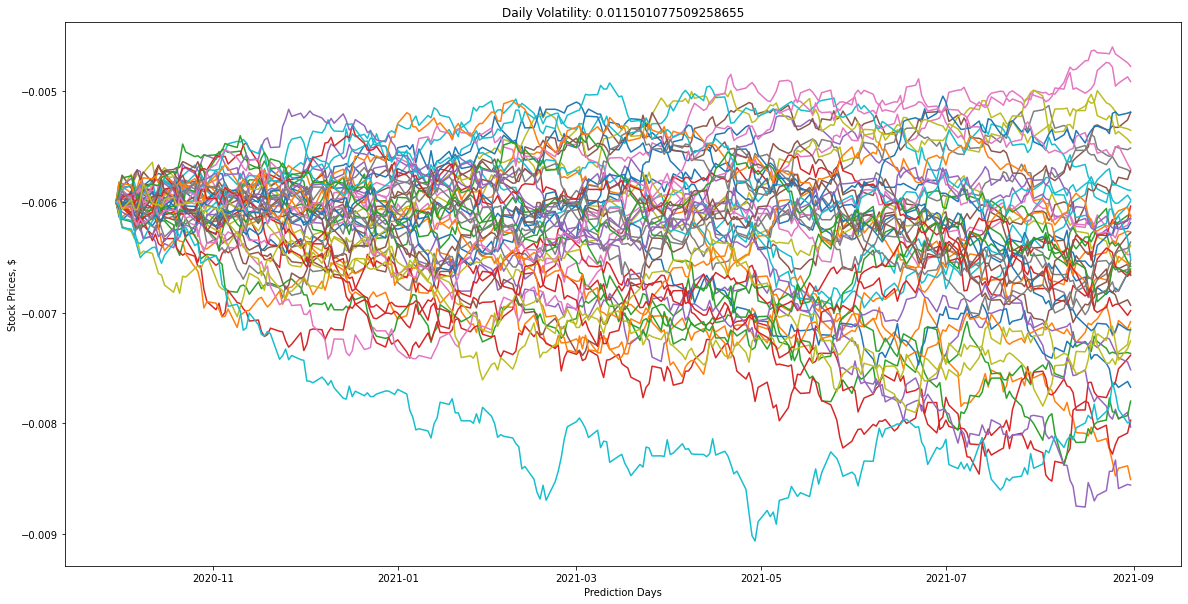

In [99]:
# Calculating drift and diffusion components
drift = (mu - 0.5 * sigma**2) * t
print(drift)
diffusion = {str(scen): sigma * W[str(scen)] for scen in range(1, scen_size + 1)}
print(diffusion)

# Making the predictions
S = np.array([So * np.exp(drift + diffusion[str(scen)]) for scen in range(1, scen_size + 1)]) 
S = np.hstack((np.array([[So] for scen in range(scen_size)]), S)) # add So to the beginning series
print(S)

# Plotting the simulations
plt.figure(figsize = (20,10))
for i in range(scen_size):
    plt.title("Daily Volatility: " + str(sigma))
    plt.plot(pd.date_range(start = df_test_1["date"].max(), 
                end = pred_end_date, freq = 'D').map(lambda x:
                x if x.isoweekday() in range(1, 6) else np.nan).dropna(), S[i, :])
    plt.ylabel('Stock Prices, $')
    plt.xlabel('Prediction Days')
plt.show()

# Dataframe format for predictions - first 10 scenarios only
Preds_df = pd.DataFrame(S.swapaxes(0, 1)[:, :10]).set_index(
           pd.date_range(start = df_test_1["date"].max(), 
           end = pred_end_date, freq = 'D').map(lambda x:
           x if x.isoweekday() in range(1, 6) else np.nan).dropna()
           ).reset_index(drop = False)

In [ ]:
spy_ret = dsf_filtered[dsf_filtered['ticker']=='SPY']
TLT_ret = dsf_filtered[dsf_filtered['ticker']=='TLT']
gld_ret = dsf_filtered[dsf_filtered['ticker']=='GLD']

spy_prc = dsf_filtered[dsf_filtered['ticker']=='SPY']
TLT_prc = dsf_filtered[dsf_filtered['ticker']=='TLT']
gld_prc = dsf_filtered[dsf_filtered['ticker']=='GLD']

# Allocate shares

In [ ]:
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

date_start = "2004-11-19"
money = 10000000
portfolio_weights = {'spy':0.5, 'tlt': 0.4, "gld": 0.1}
latest_prices = {'spy': ret_price.loc['2004-11-19']['spy_prc'], 'tlt': ret_price.loc['2004-11-19']['tlt_prc'], \
          'gld': ret_price.loc['2004-11-19']['gld_prc']}
latest_prices = pd.Series(latest_prices)

da = DiscreteAllocation(portfolio_weights, latest_prices, total_portfolio_value=10000000)
shares, cash = da.lp_portfolio()

actual_weights = [shares['spy']*latest_prices['spy']/money, 
                  shares['tlt']*latest_prices['tlt']/money, 
                  shares['gld']*latest_prices['gld']/money]
actual_weights

# Set up dataframe to track trades

In [ ]:
initial_df = np.array([[shares['spy'], latest_prices['spy'], -shares['spy']*latest_prices['spy'],shares['spy'], shares['spy']*latest_prices['spy'],
                        shares['tlt'], latest_prices['tlt'], -shares['tlt']*latest_prices['tlt'], shares['tlt'], shares['tlt']*latest_prices['tlt'],
                        shares['gld'], latest_prices['gld'], -shares['gld']*latest_prices['gld'], shares['gld'], shares['gld']*latest_prices['gld'],
                        cash]])


df_trades = pd.DataFrame(initial_df, columns = ['spy shr chg', 'spy prc', 'spy csh chg', 'spy tot shr', 'spy tot bal',
                                                'tlt shr chg', 'tlt prc', 'tlt csh chg', 'tlt tot shr', 'tlt tot bal',
                                                'gld shr chg', 'gld prc', 'gld csh chg', 'gld tot shr', 'gld tot bal', 'cash'], 
                         index = [date_start])

# Dataframe to track daily movements

In [ ]:
ret_price = pd.DataFrame([spy_ret['retx'],spy_ret['div_ret'], spy_ret['prc'], TLT_ret['retx'], TLT_ret['div_ret'], TLT_ret['prc'], gld_ret['retx'], gld_ret['div_ret'], gld_ret['prc']]).transpose()
ret_price.columns = ['spy_retx', 'spy_retd', 'spy_prc', 'tlt_retx', 'tlt_retd', 'tlt_prc', 'gld_retx', 'gld_retd', 'gld_prc']
ret_price = ret_price.dropna()
ret_price[["spy_port_retx", "tlt_port_retx", "gld_port_retx"]] = ret_price[["spy_retx", "tlt_retx", "gld_retx"]].mul(actual_weights, axis = 1).dropna()
ret_price[["spy_port_cum_retx", "tlt_port_cum_retx", "gld_port_cum_retx"]] = (ret_price[["spy_retx", "tlt_retx", "gld_retx"]]+1).cumprod()
#ret_price = ret_price.iloc[1:]
ret_price['Trading_Day_Counter'] = range(len(ret_price))

# Loop to track dividend payments and rebalance every 6 months

In [ ]:
rebalance_days = 126

for index, row in ret_price.iterrows():
    tradeflag = 0
    divflag = 0
    tlt_div_cash = 0
    spy_div_cash = 0
    gld_div_cash = 0
    rebal_spy = 0
    rebal_tlt = 0
    rebal_gld = 0
    if row['spy_retd'] > 0:
        divflag=1
        spy_div_cash = row['spy_prc']*df_trades['spy tot shr'].iloc[-1]*row['spy_retd']
        #new_spy_shares = int(spy_div_cash+df_trades['cash'].iloc[-1])/row['spy_prc']
        #leftover_cash = spy_div_cash+df_trades['cash'].iloc[-1]-(new_spy_shares*row['spy_prc'])
        #tradeflag = 1
    if row['tlt_retd'] > 0:
        divflag == 1
        #if tradeflag = 1:
        #    cash = leftover_cash
        #else:
        #    cash = df_trades['cash'].iloc[-1]
        
        tlt_div_cash = row['tlt_prc']*df_trades['tlt tot shr'].iloc[-1]*row['tlt_retd']
        #new_tlt_shares = int(tlt_div_cash+cash)/row['tlt_prc']
        #leftover_cash = tlt_div_cash+cash-(new_tlt_shares*row['tlt_prc'])
    
    if row['gld_retd'] > 0:
        divflag==1
        #if tradeflag = 1:
        #    cash = leftover_cash
        #else:
        #    cash = df_trades['cash'].iloc[-1]
        gld_div_cash = row['gld_prc']*df_trades['gld tot shr'].iloc[-1]*row['gld_retd']
        #new_gld_shares = int(gld_div_cash+cash)/row['gld_prc']
        #leftover_cash = gld_div_cash+cash-(new_gld_shares*row['gld_prc'])
    
    if row['Trading_Day_Counter'] % rebalance_days == 0:
        tradeflag = 1
        latest_prices = {'spy': row['spy_prc'], 'tlt': row['tlt_prc'], \
          'gld': row['gld_prc']}
        latest_prices = pd.Series(latest_prices)
        cur_shrs = np.array(df_trades[['spy tot shr', 'tlt tot shr','gld tot shr']].iloc[-1])
        #cum_ret = np.array(row[["spy_port_cum_retx", "tlt_port_cum_retx", "gld_port_cum_retx"]])
        #beg_bal = np.array(df_trades[["spy tot bal", 'tlt tot bal', 'gld tot bal']].iloc[-1])
        total_money = np.matmul(np.array(latest_prices),cur_shrs)+df_trades['cash'].iloc[-1]+tlt_div_cash+spy_div_cash+gld_div_cash
        
        
        da = DiscreteAllocation(portfolio_weights, latest_prices, total_portfolio_value=total_money)
        shares, cash = da.greedy_portfolio()
        rebal_spy = shares['spy']-df_trades['spy tot shr'].iloc[-1]
        rebal_tlt = shares['tlt']-df_trades['tlt tot shr'].iloc[-1]
        rebal_gld = shares['gld']-df_trades['gld tot shr'].iloc[-1]
        trade_add = pd.DataFrame([[rebal_spy, latest_prices['spy'], -rebal_spy*latest_prices['spy'],shares['spy'], shares['spy']*latest_prices['spy'],
                        rebal_tlt, latest_prices['tlt'], -rebal_tlt*latest_prices['tlt'], shares['tlt'], shares['tlt']*latest_prices['tlt'],
                        rebal_gld, latest_prices['gld'], -rebal_gld*latest_prices['gld'], shares['gld'], shares['gld']*latest_prices['gld'],
                        cash]], index = [index], columns = df_trades.columns)
        df_trades = df_trades.append(trade_add)
        print(df_trades)                  
    elif divflag == 1:
        cash = df_trades['cash'].iloc[-1]+tlt_div_cash+spy_div_cash+gld_div_cash
        trade_add = pd.DataFrame([[rebal_spy, latest_prices['spy'], -rebal_spy*latest_prices['spy'],shares['spy'], shares['spy']*latest_prices['spy'],
                        rebal_tlt, latest_prices['tlt'], -rebal_tlt*latest_prices['tlt'], shares['tlt'], shares['tlt']*latest_prices['tlt'],
                        rebal_gld, latest_prices['gld'], -rebal_gld*latest_prices['gld'], shares['gld'], shares['gld']*latest_prices['gld'],
                        cash]], index = [index], columns = df_trades.columns)
        df_trades = df_trades.append(trade_add)
        
    
    ret_price.loc[index:, ["spy_port_cum_retx", "tlt_port_cum_retx", "gld_port_cum_retx"]] = (ret_price[["spy_retx", "tlt_retx", "gld_retx"]].loc[index:]+1).cumprod()
    